In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
images = [cv2.imread("../mire_1.png"), cv2.imread("../mire_2.png")]


Nous allons adopter les conventions suivantes : les axes x,y sont tels que x correspond à la coordonnée en ligne du pixel et y correspond à la coordonnée en colonne du pixel, ainsi Nx correspond au nombre de corners en "ordonnée", Ny correspond au nombre de coordonnées en "abscisse".

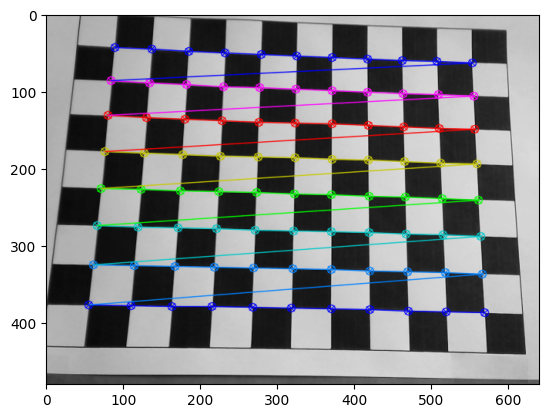

In [3]:
cnt = 1
ny = 11
nx = 8
coord_px = []
for image in images:
    ret, corners = cv2.findChessboardCorners(image, (ny, nx))
    cv2.drawChessboardCorners(image, (ny, nx), corners, ret)
    result_name = '../data/board_corners_draw'+str(cnt)+'.jpg'
    cv2.imwrite(result_name, image)
    if cnt == 1:
        plt.imshow(image)
    coord_px.append(np.flip(np.squeeze(corners)))
    cnt += 1
coord_px = np.concatenate((coord_px[0], coord_px[1]))

In [4]:
ecart_corners_x = np.linspace(0, 20*nx - 20, nx)
ecart_corners_y = np.linspace(0, 20*ny - 20, ny)
ecart_corners_z_picture_1 = np.linspace(0, 0, ny)
ecart_corners_z_picture_2 = np.linspace(-100, -100, ny)

yv, xv = np.meshgrid(ecart_corners_y, ecart_corners_x)
zv_1, xv = np.meshgrid(ecart_corners_z_picture_1, ecart_corners_x)
zv_2, xv = np.meshgrid(ecart_corners_z_picture_2, ecart_corners_x)

coord_mm = np.stack((xv, yv, zv_1), axis=2) # La coordonnée selon z est 0
coord_mm = np.concatenate((coord_mm, np.stack((xv, yv, zv_2), axis=2)), axis=0)
coord_mm = coord_mm.reshape(176, 3)

D'après le site du constructeur de webcam logitech, la référence C270 a une distance focale de 4.0 mm.

In [5]:
f = 4
height, width = images[0].shape[0]/2, images[0].shape[1]/2
i1 = height
i2 = width

In [6]:
u_1_tilde = coord_px[:,0] - height # x 
u_2_tilde = coord_px[:,1] - width # y

In [7]:
lignes = 176

In [8]:
A = np.zeros((lignes, 7))
U1 = u_1_tilde

In [9]:
for i in range(lignes):
    A[i] = np.array([u_2_tilde[i]*coord_mm[i,0], u_2_tilde[i]*coord_mm[i,1], u_2_tilde[i]*coord_mm[i,2], u_2_tilde[i], -u_1_tilde[i]*coord_mm[i,0], -u_1_tilde[i]*coord_mm[i,1], -u_1_tilde[i]*coord_mm[i,2]])

In [10]:
L = np.linalg.inv(A.T @ A) @ A.T @ U1

Calcul des paramètres de L :

In [11]:
o_2_c_abs = 1/(np.sqrt(L[4]**2+L[5]**2+L[6]**2))
o_2_c = o_2_c_abs
beta = o_2_c_abs * np.sqrt(L[0]**2+L[1]**2+L[2]**2)
o_1_c = L[3] * o_2_c / beta
r11 = L[0] * o_2_c / beta
r12 = L[1] * o_2_c / beta
r13 = L[2] * o_2_c / beta
r21 = L[4] * o_2_c
r22 = L[5] * o_2_c
r23 = L[6] * o_2_c


Déduction des paramètres de la matrice de rotation de la matrice extrinsèque : 

In [12]:
R1 = np.array([r11, r12, r13])
R2 = np.array([r21, r22, r23])
R3 = np.cross(R1, R2)
r31, r32, r33 = R3[0], R3[1], R3[2]

Calcul des angles de rotation entre l'espace caméra et l'espace monde :

In [13]:
phi = - np.arctan(r23/r33)
gamma = - np.arctan(r12/r11)
omega = np.arctan(r13/(-r23*np.sin(phi)+r33*np.cos(phi)))
print(phi)
print(gamma)
print(omega)

0.09817052032772595
-0.03312040488057765
0.18941040735109518


In [14]:
B = np.zeros((lignes, 2))
R = np.zeros((lignes, 1))
for i in range(lignes):
    R[i] = -u_2_tilde[i] * (r31*coord_mm[i, 0]+r32*coord_mm[i, 1]+r33*coord_mm[i, 2])
    B[i] = np.array([u_2_tilde[i], -(r21*coord_mm[i, 0] + r22*coord_mm[i, 1] + r23*coord_mm[i, 2] + o_2_c)])

In [15]:
F = np.squeeze(np.linalg.pinv(B.T @ B) @ B.T @ R)
o_3_c = F[0]
f2 = F[1]

In [16]:
s2 = f/f2
f1 = beta * f2
s1 = f/f1

In [17]:
M_int = np.array(
    [[f/s1, 0, i1, 0],
     [0, f/s2, i2, 0],
     [0, 0, 1, 0]]
)
M_ext = np.array(
    [[r11, r12, r13, o_1_c],
     [r21, r22, r23, o_2_c],
     [r31, r32, r33, o_3_c],
     [0, 0, 0, 1]]
)
M = M_int @ M_ext

Nous avons donc calculé M, la matrice de transformation qui permet le changement de repère : repère objet à l'espace image pixellisé. Il faut donc vérifier la cohérence de  nos calculs. Pour cela nous allons réutiliser les points de l'espace objet de la variable coord_mm. Les 88 premiers points correspondant aux 88 coordonnées de l'image "mire_1", seront multiplié à la matrice M. La relation suivante montre les résultat de la matrice de gauche attendu: u1 et u2 correspondent aux coordonnées dans l'espace image en pixel de l'image. Ainsi il faut normalisé par alpha la valeur obtenu en sortie du produit M par coord_mm pour obtenir les réelles valeurs en pixel.

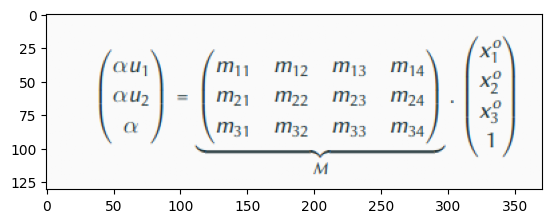

In [18]:
im = plt.imread("../data/relation_pixel_objet.png")
plt.imshow(im)
plt.show()

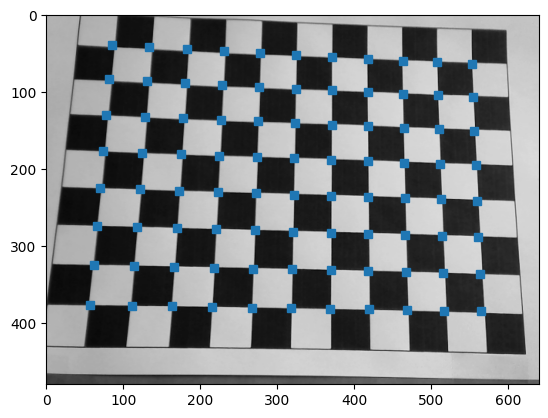

In [19]:
im = plt.imread("../mire_1.png")
fig, ax = plt.subplots()
U = np.ndarray((88,1))
V = np.ndarray((88,1))
for i in range(int(lignes/2)):
    alpha_U = M @ np.append(coord_mm[i, :], 1)
    alpha = alpha_U[2]
    U[i] = alpha_U[0] / alpha
    V[i] = alpha_U[1] / alpha

U = np.squeeze(U)
V = np.squeeze(V)
plt.plot(V, U, 's')
plt.imshow(im)
plt.show()